In [1]:
import torch 
import torch.nn as nn
import torchvision
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.ModuleList()

        self.disc.append(nn.Linear(in_features, 128))
        self.disc.append(nn.LeakyReLU(0.1))
        self.disc.append(nn.Linear(128, 1))
        self.disc.append(nn.Sigmoid())

    def forward(self, x):
        for layer in self.disc:
            x = layer(x)
        return x 
        
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.generator = nn.ModuleList()

        self.generator.append(nn.Linear(z_dim, 256))
        self.generator.append(nn.LeakyReLU(0.1))
        self.generator.append(nn.Linear(256, 512))
        self.generator.append(nn.LeakyReLU(0.1))
        self.generator.append(nn.Linear(512, img_dim))
        self.generator.append(nn.Tanh())

    def forward(self, x):
        for layer in self.generator:
            x = layer(x)
        return x


class MNIST_Dataset(torch.utils.data.Dataset):
    def __init__(self, files_addr, transforms):
        super().__init__()
        self.samples = pd.read_csv(files_addr, header=None)
        self.transforms = transforms

    
    
    def __getitem__(self, index):
        data = np.array(self.samples.iloc[index][1:], dtype=np.float64).reshape((28, 28 ,1))
        data = self.transforms(data)
        label = np.array(self.samples.iloc[index][0])
        return data, label 

    def __len__(self):
        return len(self.samples)

In [3]:
def save_results(images, addr):
    images = images.detach().cpu().numpy()
    for image_index in range(images.shape[0]):
        plt.subplot(4, 8, image_index+1)
        plt.axis("off")
        plt.imshow(images[image_index].reshape(28, 28, 1), cmap="gray")

    plt.savefig(addr, dpi=600)

In [4]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

LEARNING_RATE = 3e-4
Z_DIM = 64
IMAGE_DIM = 28*28*1
BATCH_SIZE = 32
NUM_EPOCHS = 500

array_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                    torchvision.transforms.Lambda(lambda x : (x/255.)*2 - 1),
                                                    ])

train_data_addr = "E:/Hamavar/GenerativeAI/GAN/MNIST_CSV/mnist_train.csv"


In [5]:
disc = Discriminator(IMAGE_DIM).to(torch.float64).to(device)
gen = Generator(Z_DIM, IMAGE_DIM).to(torch.float64).to(device)

fixed_noise = torch.randn((BATCH_SIZE, Z_DIM)).to(torch.float64).to(device)

mnist_dataset = MNIST_Dataset(train_data_addr, transforms=array_transforms)
mnist_dataloader = torch.utils.data.DataLoader(dataset=mnist_dataset, batch_size=BATCH_SIZE)

opt_disc = torch.optim.Adam(disc.parameters(), lr=LEARNING_RATE)
opt_gen = torch.optim.Adam(gen.parameters(), lr=LEARNING_RATE)

criterion = nn.BCELoss()

In [6]:
dataset = MNIST_Dataset(files_addr=train_data_addr, transforms=array_transforms)
mnist_dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
mean_of_disc_loss = list()
mean_of_gen_loss = list()

Epoch : 0, Disc Loss : 0.35078069278842533, Gen Loss : 1.7725439383965562
Epoch : 1, Disc Loss : 0.6300475633783226, Gen Loss : 1.0500546990567001
Epoch : 2, Disc Loss : 0.683116584921036, Gen Loss : 0.9519566734187531
Epoch : 3, Disc Loss : 0.7344287515749754, Gen Loss : 0.8542990524276967
Epoch : 4, Disc Loss : 0.6985968583095455, Gen Loss : 0.9153678118669437
Epoch : 5, Disc Loss : 0.7094388467645927, Gen Loss : 0.8870849329075776
Epoch : 6, Disc Loss : 0.6835978454403212, Gen Loss : 0.9186986039220798
Epoch : 7, Disc Loss : 0.7169487217916809, Gen Loss : 0.8701842008446267
Epoch : 8, Disc Loss : 0.674328164448607, Gen Loss : 0.9369270120830943
Epoch : 9, Disc Loss : 0.6908475712120873, Gen Loss : 0.9221138101306771
Epoch : 10, Disc Loss : 0.6309338095836351, Gen Loss : 1.077851364315025
Epoch : 11, Disc Loss : 0.6342192663665139, Gen Loss : 1.1131373905721702
Epoch : 12, Disc Loss : 0.6530800431593634, Gen Loss : 0.9835703184702019
Epoch : 13, Disc Loss : 0.6433279188554787, Gen Lo

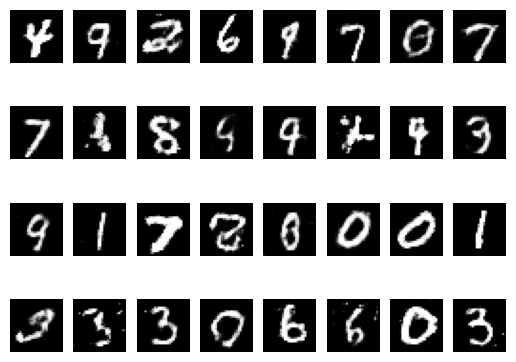

In [8]:
for epoch in range(NUM_EPOCHS):
    epoch_mean_of_disc_loss = list()
    epoch_mean_of_gen_loss = list()
    
    for data, label in mnist_dataloader:
        real = data.view(-1, 28*28).to(torch.float64).to(device)
        # Train Discriminator: max log(D(real)) + log(1-D(G(z))) 
        noise = torch.randn(BATCH_SIZE, Z_DIM).to(torch.float64).to(device)
        fake = gen(noise)
        
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        
        disc_fake = disc(fake.detach()).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake)/2

        disc.zero_grad()
        lossD.backward()
        opt_disc.step()

        # Train Generator
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))

        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        epoch_mean_of_disc_loss.append(lossD.detach().cpu())
        epoch_mean_of_gen_loss.append(lossG.detach().cpu())

    mean_of_disc_loss.append(np.mean(epoch_mean_of_disc_loss))
    mean_of_gen_loss.append(np.mean(epoch_mean_of_gen_loss))
    
    print(f"Epoch : {epoch}, Disc Loss : {mean_of_disc_loss[-1]}, Gen Loss : {mean_of_gen_loss[-1]}")
    with torch.no_grad():
        output = gen(fixed_noise)
        save_results(output, f"E:/Hamavar/GenerativeAI/GAN/simpleGAN/results/generated_numbers/epoch_{epoch}.png")
        torch.save(gen.state_dict(), f"E:/Hamavar/GenerativeAI/GAN/simpleGAN/results/models/epoch_{epoch}.pt")
    


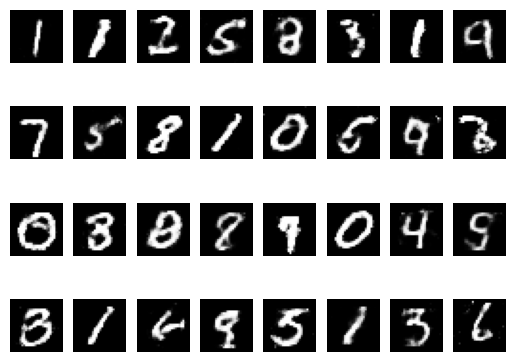

In [11]:
############ inference ###################
model = Generator(Z_DIM, IMAGE_DIM).to(torch.float64).to(device)
model.load_state_dict(torch.load("E:/Hamavar/GenerativeAI/GAN/simpleGAN/results/models/epoch_500.pt"))
model.eval()


fixed_noise = torch.randn((BATCH_SIZE, Z_DIM)).to(torch.float64).to(device)

with torch.no_grad():
    output = model(fixed_noise)
    save_results(output, f"E:/Hamavar/GenerativeAI/GAN/simpleGAN/results/generated_numbers/epoch_{epoch}.png")